In [1]:
#!pip install redis
#!pip install wordcloud
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
from tqdm import tqdm
from dateutil import tz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import pickle
import redis
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from lib.conn_postgres import connect_to_postgres as conpg

In [2]:
conn, cur = conpg(location = 'postgres')
sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags, date, time, date_time  
                from tweets where (date_time >= NOW() - '12 hour'::INTERVAL) and hashtags is not null and hashtags != 'None';'''
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)
df['created_datetime'] = pd.to_datetime(df['created_at'])
df['year'] = df.created_datetime.apply(lambda x: x.year)
df['month'] = df.created_datetime.apply(lambda x: x.month)
df['day'] = df.created_datetime.apply(lambda x: x.day)
df['hour'] = df.created_datetime.apply(lambda x: x.hour)
len(df)

12282

In [3]:
df = df[~df['hashtags'].str.contains('amp')]
df = df[~df['hashtags'].str.contains('job|hiring|sales|retail|clerical')]
df = df[~df['hashtags'].str.contains('dallas|plano|irving|richardson|garland|allen|odessa|midland|sanfrancisco|losangeles|irvine|garland')]
len(df)

In [6]:
#df[~df['location'].str.contains('.ca|california')][~df['location'].str.contains('.tx|texas')]
ca_df = df[df['location'].str.contains('.ca|california')]
tx_df = df[df['location'].str.contains('.tx|texas')]

In [7]:
def word_cloud(state = None): 
    state = state.lower()
    state_df = df[df['location'].str.contains('.{}'.format(state))]
    words = state_df['hashtags'][(state_df['hashtags'].isnull() == False) & (state_df['hashtags'] != 'None')]
    stopwords = set(STOPWORDS)
    #stopwords.add("amp")
    wc = WordCloud(width=1600, height=800, background_color='white', \
                   relative_scaling=1, stopwords=stopwords, colormap='copper').generate(' '.join(i for i in words))
    plt.figure(figsize=(16,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

In [10]:
hastages_series = df['hashtags']
len(hastages_series)

9554

In [11]:
count_vectorizer = CountVectorizer(min_df = 1, stop_words='english')
hashtags_countvec = count_vectorizer.fit_transform(hastages_series)
#hashtags_countvec = pickle.dumps(hashtags_countvec_fit)
#r.set('hashtags_countvec_fit_temp', hashtags_countvec)
#hashtags_countvec = pickle.loads(r.get('hashtags_countvec_fit_temp'))

In [13]:
def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [14]:
def new_trend_period(trend_group):        
    new_result = []
    count = 0
    for i in range(len(trend_group)-1):
        if (count > len(trend_group)-2):
            pass
        else:
            gap = ((trend_group[count+1][0]) - (trend_group[count][len(trend_group[count])-1]))
            if gap <.8*min((trend_group[count+1][0]), (trend_group[count][len(trend_group[count])-1])):
                new_period = trend_group[count]+trend_group[count+1]
                new_result.append(new_period)
                count +=2
            else:
                new_result.append(trend_group[count])
                count +=1
    return new_result

In [26]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
min_time = min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .3)
time_gap = timedelta(hours = .1)
windows = int(round(time_delta/time_gap,0))
time_format = '%Y-%h-%d %a %I %p'
from_zone = tz.tzutc()
#to_zone = tz.tzlocal()
to_zone = 'US/Pacific'
def hashtag_trend(hashtag):
    hashtag = hashtag.lower()
    arr = []
    arr_all = []
    start_time = min_time
    for window in range(windows):
        start_time = start_time
        end_time = start_time + time_lag
        subset = df['hashtags'][((df['created_datetime'] < end_time) & (df['created_datetime'] > start_time))]
        h = subset.str.contains(hashtag).mean()
        arr.append(h)
        start_time += time_gap
    w = np.array(range(windows))
    timeline = []
    for i in w:
        timeline.append(min(df['created_datetime']) + time_gap * i) 
    arr = np.array(arr)  
    grad = np.gradient(arr)
    time_df = pd.DataFrame({'arr':arr,'grad':grad},index=timeline)
    rolmean_arr = pd.rolling_mean(arr, window=12)
    rolstd_arr = pd.rolling_std(arr, window=12)
    rolmean_grad = np.gradient(rolmean_arr)
    spike = []
    trend = np.argwhere(rolmean_grad>0.001).reshape(1,-1)[0]
    trend_group = group_consecutives(trend)
        
    trend_group1 = new_trend_period(trend_group)
    #if trend_group1 != trend_group:
    #    trend_group1 = new_trend_period(trend_group1)
        
    trend_group2 = [i for i in trend_group1 if (len(i) > 7)]
    spike.append([[i[0],i[len(i)-1]] for i in trend_group2])
    spike = np.array(spike)
    spk1 = [i[0] for i in spike[0]]
    spk2 = [i[1] for i in spike[0]] 
    predict, interval = get_arima(arr)
    new_predict = np.append(arr,predict)
    upper = np.append(arr,interval[:,0])
    lower = np.append(arr,interval[:,1])
    plt.figure(figsize=(20,10))
    plt.axvline(w[-1], color = 'gray',linestyle='dashed')
    plt.plot(new_predict, c = 'dimgray',linewidth = 2, label = 'Prediction')
    plt.plot(upper, c = 'lightgray',linestyle='dashed', label = 'error')
    plt.plot(lower, c = 'lightgray',linestyle='dashed')
    plt.plot(arr, label='Hashtag Frequency',c = 'navy',linewidth = 3)
    plt.plot(rolmean_arr, label='Rolling Means',c = 'limegreen')
    plt.plot(rolstd_arr, label='Rolling STDs',c = 'yellowgreen')
    plt.plot(rolmean_grad, label='Gradient over Rolling Means',c = 'red')
    for j,k in zip(spk1,spk2):
        spike1 = (min_time + time_gap * j) 
        spike1 = spike1.replace(tzinfo=from_zone)
        spike1_et = spike1.astimezone(to_zone)
        spike1_et = spike1_et.strftime(time_format)
       
        spike2 = (min_time + time_gap * k) 
        spike2 = spike2.replace(tzinfo=from_zone)
        spike2_et = spike2.astimezone(to_zone)
        spike2_et = spike2_et.strftime(time_format)           
        plt.axvline(j, color = 'salmon',linestyle='dashed', label = 'Trending: {}'.format(spike1_et))
        plt.axvspan(j, k, alpha=0.2, color='lightcoral')
    plt.title(hashtag, fontsize=20)    
    plt.legend(fontsize=12) 
    plt.show()
    return  

In [16]:
def get_arima(arr):
    from statsmodels.tsa.arima_model import ARIMA
    w = np.array(range(windows))
    timeline = []
    for i in w:
        timeline.append(min_time + time_gap * i) 
    arima_df = pd.DataFrame({'perf':arr})   
    series = arima_df.dropna()
    model = ARIMA(np.array(series.values), order=(12,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=20)
    predict = forecast[0]+arr[-1]
    interval = forecast[2]+arr[-1]
    return predict, interval

In [17]:
hashtag_freq_df = pd.DataFrame({'hashtag': count_vectorizer.get_feature_names(), 'occurrences':np.asarray(hashtags_countvec.sum(axis=0)).ravel().tolist()})
hashtag_freq_df['frequency'] = hashtag_freq_df['occurrences']/np.sum(hashtag_freq_df['occurrences'])
hashtag_freq_df.sort_values(by = 'occurrences',ascending = False, inplace = True)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


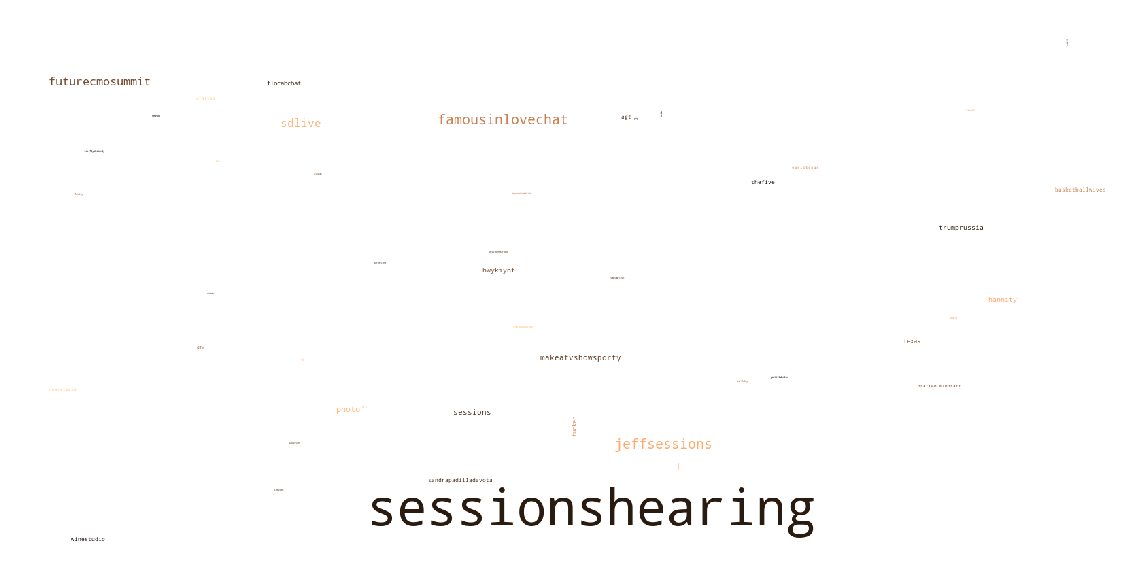

In [8]:
word_cloud('TX')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


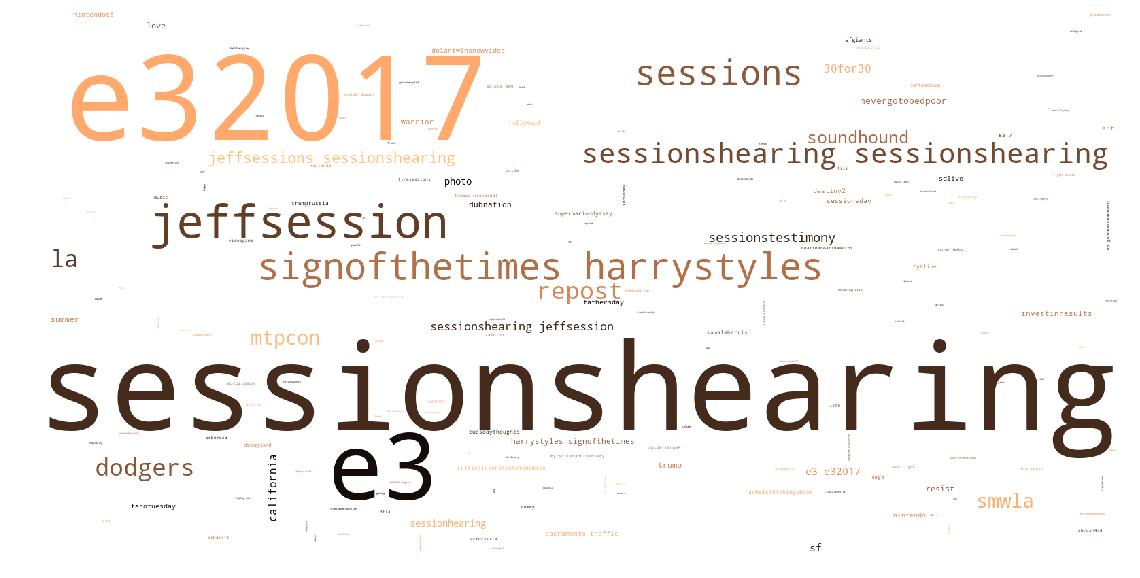

In [9]:
word_cloud('CA')

In [12]:
time_delta = max(df['created_datetime']) - min(df['created_datetime'])
time_window = time_delta.components.days*24 + time_delta.components.hours
time_lag = timedelta(hours = .25)
time_gap = timedelta(hours = 0.1)
windows = int(round(time_delta/time_gap,0))
print('start time: ', min(df['created_datetime']),'\n',\
      'end time:  ', max(df['created_datetime']),'\n',\
      'total hours: ',time_window,'\n',\
      'time lag: ', time_lag,'\n',\
      'time gap: ', time_gap,'\n',\
      'time windows: ', windows)

start time:  2017-06-13 18:07:38 
 end time:   2017-06-14 02:37:39 
 total hours:  8 
 time lag:  0:15:00 
 time gap:  0:06:00 
 time windows:  85


In [18]:
hashtag_freq_df.head(10)

,hashtag,occurrences,frequency
6953,sessionshearing,703,0.039525
2311,e32017,454,0.025526
2308,e3,352,0.019791
4068,jeffsessions,239,0.013438
6950,sessions,116,0.006522
3472,harrystyles,96,0.005398
7105,signofthetimes,95,0.005341
5587,nowplaying,74,0.004161
7224,smwla,71,0.003992
2105,dodgers,69,0.003879


In [ ]:
[hashtag_trend(i) for i in (hashtag_freq_df['hashtag'].head(2))]

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:31: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


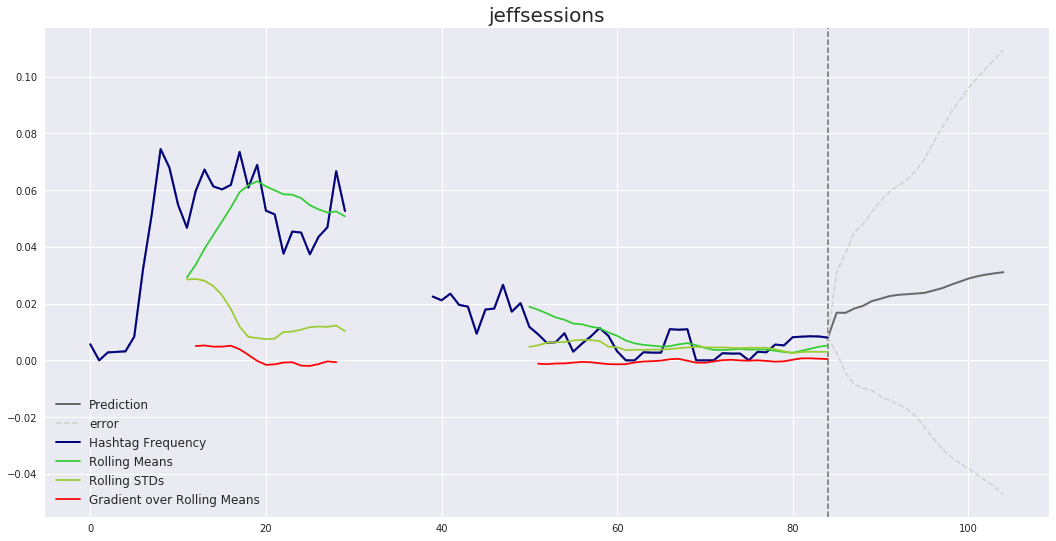

In [25]:
hashtag_trend('jeffsessions')

as the rolling std increase the tweet freq increases 
if the rolling std decrease, the tweet freq decrease

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
w = np.array(range(windows))
timeline = []
for i in w:
    timeline.append(start_time + time_gap * i) 
#arima_df = pd.DataFrame({'perf':arr},index=timeline)   
series = np.array(arr)
series = series[~np.isnan(series)]
model = ARIMA(series, order=(12,1,0))
model_fit = model.fit()
print(model_fit.summary())
 # plot residual errors
residuals =pd. DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())